---

$$\boxed{\color{pink}{\text{Agentic AI Workshop Day-2}}}$$

$${\color{yellow}{\underline{\text{Theme}}}: \text{retrieval augmented generation (RAG)}}$$

$${\color{yellow}{\underline{\text{Goal}}}: \text{scale retrieval using RAG}}$$


**Topics**:

1. Understand why embeddings alone are not enough

2. Build a retrieval pipeline using FAISS

3. Connect retrieval → generation (RAG)

4. Run local multilingual LLM inference

5. Generate crime summaries

6. Evaluate when RAG helps and when it fails

---


---

Import libraries

---

In [45]:
import pandas as pd
import numpy as np
import math
import random
import os
import sys
import re
from tqdm import tqdm
import unicodedata
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('dark_background')
%matplotlib inline

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch: 2.9.1+cpu
CUDA available: False


---

Mount Google Drive if running in Colab

---

In [46]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    DIR = '/content/drive/MyDrive/Colab Notebooks/MAHE/MSIS Coursework/OddSem2025MAHE/Share/Agentic Workshop/NoStudentAccess'
    DATA_DIR = DIR + '/Data/'
    !pip install faiss-cpu --quiet
    os.chdir(DIR)
else:
    DATA_DIR = '../Data/'

---

Load Udupi crime data

Expected CSV columns:

- Crime Type
- Location
- Day of Week (label encoded: 0–6)
- Time of Day (0–3)
- Day
- Month
- Year
- Crime Description (Kannada text)

---

In [47]:
## Load Udupi crime data
file = DATA_DIR+'UdupiCrimeData.csv'
df= pd.read_csv(file, header = 0).dropna()
df.reset_index(inplace = True)

print('Udupi crime dataset')
print('-----------')
print('Number of records = %d'%(df.shape[0]))
print('Number of features = %d\n'%(df.shape[1]))
df.head(5)

Udupi crime dataset
-----------
Number of records = 13457
Number of features = 9



,index,Crime Type,Location,Day of Week,Time of Day,Day,Month,Year,Crime Description
0,0,ಮಟ್ಕಾ ಜುಗಾರಿ ಪ್ರಕರಣ,ಗಂಗೊಳ್ಳಿ,6.0,2.0,29.0,2.0,2020.0,ಭೀಮಶಂಕರ್ ಎಸ್ ಎಸ್ ಪಿ ಎಸ್ ಐ ಗಂಗೊಳ್ಳಿ ಪೊಲಿಸ್ ಠಾಣೆ...
1,1,ಅಸ್ವಾಭಾವಿಕ ಮರಣ ಪ್ರಕರಣ,ಕೊಲ್ಲೂರು,6.0,0.0,29.0,2.0,2020.0,ಪಿರ್ಯಾದಿದಾರರಾಧ ಶ್ರೀಮತಿ ಸಂಧ್ಯಾ ( 59 ವರ್ಷ) ಗಂಡ: ...
2,2,ಅಸ್ವಾಭಾವಿಕ ಮರಣ ಪ್ರಕರಣ,ಉಡುಪಿ,6.0,1.0,29.0,2.0,2020.0,"ಪಿರ್ಯಾದಿದಾರರಾದ ಕೆ ರಾಘವೇಂದ್ರ ಸರಳಾಯ(67), ತಂದೆ: ದ..."
3,3,ಮನುಷ್ಯ ಕಾಣೆ ಪ್ರಕರಣ,ಶಿರ್ವಾ,4.0,0.0,27.0,2.0,2020.0,"ಪಿರ್ಯಾದಿದಾರರಾದ ಕಿಶೋರ್‌ಆಚಾರ್ಯ (31), ತಂದೆ:ಉಪೇಂದ್..."
4,8,ಅಪಘಾತ ಪ್ರಕರಣ,ಮಲ್ಪೆ,5.0,1.0,21.0,2.0,2020.0,ದಿನಾಂಕ 21/02/2020 ರಂದು 14:00 ಗಂಟೆಗೆ ಪಿರ್ಯಾದಿದಾ...


---

User-defined functions for normalizing Kannada text and tokenizing the resulting normalized text


---

In [48]:
def normalize_text(text):
  text = str(text)
  # Remove every character that is NOT a Kannada character OR whitespace leaving only Kannada letters,
  # vowels, and matras, and spaces and line breaks.
  # Unicode range for Kannada: U+0C80 – U+0CFF, Devanagari: U+0900 – U+097F, Tamil: U+0B80 – U+0BFF
  text = re.sub(r"[^\u0C80-\u0CFF\s]", "", text)
  # Replace one or more whitespace characters with a single space
  text = re.sub(r"\s+", " ", text)
  return text.strip()

def tokenize(text):
  return normalize_text(text).split()

---

Load pretrained embedding model and embed crime reports

---

In [49]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer(
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)

texts = df["Crime Description"].apply(normalize_text).tolist()

# Embed crime reports into an embedding matrix

X_embeddings = embedder.encode(texts,
                               batch_size = 32,
                               show_progress_bar = True,
                               convert_to_numpy = True)

d:\Programs\Miniconda3\envs\agentic\lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/421 [00:00<?, ?it/s]

---

**FAISS Index (Scalable Retrieval)**:

- Fast Approximate Nearest Neighbor Search
  
- Optimized for large vector collections
  
- Used in real-world RAG systems
  
---

In [50]:
import faiss

In [51]:
## Build FAISS index for embeddings built using
## the pretrained model
dim = X_embeddings.shape[1]

index = faiss.IndexFlatL2(dim)
index.add(X_embeddings)

index.ntotal

13457

In [53]:
## User-defined function for retrieving top-5
## similar embeddings
def retrieve(query, k = 5):
    query = normalize_text(query)
    q_emb = embedder.encode([query], convert_to_numpy = True)
    distances, indices = index.search(q_emb, k)
    return df.iloc[indices[0]]['Crime Description']

In [54]:
## Test retrieval and inspect the top result
query = "ಮೊಬೈಲ್ ಫೋನ್ ಕಳವು"
results = retrieve(query)
print(results)
print(f'Top result {results.index[0]}:\n {results[results.index[0]]}')

2947     ಪಿರ್ಯಾದಿದಾರರಾದ ಹರೀಶ್‌ ಶೆಟ್ಟಿ, ತಂದೆ: ಪರಮೇಶ್ವರ್ ...
8440     ಬೆಳ್ಳೆ ಗ್ರಾಮ ಪಂಚಾಯತ್‌ ವ್ಯಾಪ್ತಿಯ ಕುಕ್ಕುದಕಟ್ಟೆ ಎ...
6866     ಪಿರ್ಯಾದಿದಾರರಾದ ಆರ್. ವಸಂತ ಪ್ರಭು (46), ತಂದೆ:ಆರ್ ...
13300    ಕಸ್ತೂರ್ಬಾ ಆಸ್ಪತ್ರೆ ಮಣಿಪಾಲ Cardiology Deptನಲ್ಲಿ...
597      ಪಿರ್ಯಾದಿದಾರರಾದ ರಘುರಾಮ ಶೆಟ್ಟಿ(66) ತಂದೆ: ಶ್ಯಾಮ್ ...
Name: Crime Description, dtype: object
Top result 2947:
 ಪಿರ್ಯಾದಿದಾರರಾದ ಹರೀಶ್‌ ಶೆಟ್ಟಿ, ತಂದೆ: ಪರಮೇಶ್ವರ್ ಶೆಟ್ಟಿ, ವಾಸ: Yentuvaraha Mane, Via Kinnigoli, Mulki, ಏಲತ್ತೂರು ಗ್ರಾಮ, ಮಂಗಳೂರು ಇವರ ಅಣ್ಣ ದಿನೇಶ್‌ ಶೆಟ್ಟಿ(55) ರವರು ಮುಂಬೈಯಲ್ಲಿ ಕೆಲಸ ಮಾಡಿಕೊಂಡಿದ್ದವರು ದಿನಾಂಕ 22/03/2019 ರಂದು ರಾತ್ರಿ 8:30 ಗಂಟೆಗೆ ಸುಕುಮಾರ ತಿಂಗಳಾಯರೊಂದಿಗೆ ಮುಂಬೈಯಿಂದ ಮುಲ್ಕಿಗೆ ರೈಲಿನ್ನಲ್ಲಿ ಹೊರಟವರು ದಿನಾಂಕ 23/03/2019 ರಂದು ಬೆಳಿಗ್ಗೆ 5:30 ಗಂಟೆಗೆ ಇಂದ್ರಾಳಿ ರೈಲ್ವೆ ಸ್ಟೇಷನ್‌ ತಲುಪುವ ಮಾರ್ಗದಲ್ಲಿ ಹೃದಯಘಾತದಿಂದ ಮೃತಪಟ್ಟಿರುವುದಾಗಿದೆ. ಈ ಬಗ್ಗೆ ಮಣಿಪಾಲ ಪೊಲೀಸ್ ಠಾಣಾ ಯು.ಡಿ.ಆರ್ ಕ್ರಮಾಂಕ 18/2019 ಕಲಂ: 174 ಸಿ.ಆರ್.ಪಿ.ಸಿ ಯಂತೆ ಪ್ರಕರಣ ದಾಖಲಾಗಿರುತ್ತದೆ.


---

Custom embedder module inherited from nn.Module

---

In [55]:
## Simple embedder module
class SimpleEmbedder(nn.Module):
    def __init__(self, vocab_size, dim = 8):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, dim)

    def forward(self, x):
        return self.embed(x).mean(dim = 0)

In [56]:
## Build a dictionary of crime groups with the
## keys as the crime types and the values as a list
## of crime descriptions corresponding to that type
crime_groups = defaultdict(list)

# Voicabulary dictionary
vocab_counter = Counter()

for index, row in df.iterrows():
    tokens = tokenize(texts[index])
    vocab_counter.update(tokens)
    crime_groups[row['Crime Type']].append(tokens)

In [57]:
# Build dictionaries for training the custom embedding model
word2idx = {w:i for i, w in enumerate(vocab_counter.keys())}
idx2word = {i:w for w, i in word2idx.items()}

In [58]:
## User-defined function to encode the crime reports
def encode_doc(tokens):
    return [word2idx[t] for t in tokens if t in word2idx]

In [59]:
## Custom embedding model based on the crime type
# Model
embed_dim = 64
model = SimpleEmbedder(len(word2idx), dim = embed_dim)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-03)
# Loss function
loss_fn = nn.CosineEmbeddingLoss()

In [60]:
## Custom embedding training loop
num_epochs = 100
epoch_loss = []

for epoch in range(num_epochs):
    total_loss = 0.0

    for crime_type, docs in crime_groups.items():
        # If a crime type has only one crime description
        # then no contribution to training
        if len(docs) < 2:
            continue

        # Pull tokens for a positive pair
        d1_tokens, d2_tokens = random.sample(docs, 2)

        # Pull tokens for a negative pair
        neg_crime = random.choice([ct for ct in crime_groups.keys() if ct != crime_type])
        d3_tokens = random.choice(crime_groups[neg_crime])

        # Encode the positive and negative pairs of documents
        d1 = torch.tensor(encode_doc(d1_tokens))
        d2 = torch.tensor(encode_doc(d2_tokens))
        d3 = torch.tensor(encode_doc(d3_tokens))

        # Forward pass
        e1 = model(d1)
        e2 = model(d2)
        e3 = model(d3)

        # Losses
        pos_label = torch.tensor(1.0)
        neg_label = torch.tensor(-1.0)
        loss_pos = loss_fn(e1, e2, pos_label)
        loss_neg = loss_fn(e1, e3, neg_label)
        loss = loss_pos + loss_neg

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss.append(total_loss)
    print(f'Epoch {epoch} loss: {total_loss:.4f}')


Epoch 0 loss: 88.9974
Epoch 1 loss: 87.9765
Epoch 2 loss: 84.8807
Epoch 3 loss: 83.6857
Epoch 4 loss: 79.1870
Epoch 5 loss: 78.3373
Epoch 6 loss: 75.4940
Epoch 7 loss: 77.2715
Epoch 8 loss: 70.3584
Epoch 9 loss: 71.5190
Epoch 10 loss: 71.5530
Epoch 11 loss: 69.2210
Epoch 12 loss: 69.0694
Epoch 13 loss: 65.8411
Epoch 14 loss: 66.9930
Epoch 15 loss: 62.5341
Epoch 16 loss: 64.8823
Epoch 17 loss: 62.0176
Epoch 18 loss: 58.2315
Epoch 19 loss: 57.2337
Epoch 20 loss: 59.7102
Epoch 21 loss: 56.2805
Epoch 22 loss: 58.0170
Epoch 23 loss: 56.5707
Epoch 24 loss: 54.6838
Epoch 25 loss: 52.4883
Epoch 26 loss: 53.7274
Epoch 27 loss: 53.0932
Epoch 28 loss: 50.1910
Epoch 29 loss: 50.8321
Epoch 30 loss: 49.0134
Epoch 31 loss: 48.1353
Epoch 32 loss: 51.4306
Epoch 33 loss: 44.6991
Epoch 34 loss: 47.6616
Epoch 35 loss: 45.8824
Epoch 36 loss: 48.0003
Epoch 37 loss: 47.1835
Epoch 38 loss: 45.2170
Epoch 39 loss: 42.7781
Epoch 40 loss: 47.7315
Epoch 41 loss: 44.8473
Epoch 42 loss: 46.1129
Epoch 43 loss: 41.167

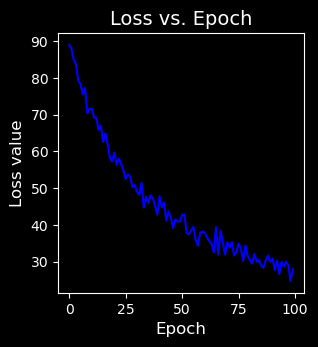

In [61]:
## Plot loss as a function of epoch:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
fig.tight_layout(pad = 4.0)
ax.plot(epoch_loss, 'b')
ax.set_xlabel('Epoch', fontsize = 12)
ax.set_ylabel('Loss value', fontsize = 12)
ax.set_title('Loss vs. Epoch', fontsize = 14);

In [62]:
## Generate custom embeddings for the crime reports

# Create empty embeddings matrix
X_customembeddings = np.empty((df.shape[0], embed_dim))

# Populate the embeddings matrix with the custom embeddings
for i in range(df.shape[0]):
  X_customembeddings[i] = model.forward(torch.tensor(encode_doc(texts[i]))).detach().numpy()


In [63]:
# Build FAISS index for embeddings built using
## the custom embedding model
dim = X_customembeddings.shape[1]

index = faiss.IndexFlatL2(dim)
index.add(X_customembeddings)

index.ntotal

13457

In [64]:
## User-defined function for retrieving top-5
## similar embeddings
def semantic_search(query, k = 5):
  query = normalize_text(query)
  q_emb = model.forward(torch.tensor(encode_doc(query))).detach().numpy().reshape(1, -1)
  distances, indices = index.search(q_emb, k)
  return df.iloc[indices[0]]['Crime Description']


In [75]:
## Test retrieval and inspect the top result
query = "ಮೊಬೈಲ್ ಫೋನ್ ಕಳವು"
results = semantic_search(query)
print(results)
print(f'Top result {results.index[0]}:\n {results[results.index[0]]}')

10730    ದಿನಾಂಕ 30/06/2016 ರಂದು 15:00 ಗಂಟೆಗೆ ಪಿರ್ಯಾದಿದಾ...
13393    ದಿನಾಂಕ. 11/08/2015 ರಂದು ಮದ್ಯಾಹ್ನ 2:30 ಗಂಟೆಯ ಸಮ...
11901    ಅಬ್ದುಲ್‌ ರೆಹಮಾನ್‌ ಪ್ರಾಯ 31 ವರ್ಷ ತಂದೆ: ಅಬ್ದುಲ್‌...
11197    ದಿನಾಂಕ 05/05/2016 ರಂದು ಸಂಜೆ 6:00 ಗಂಟೆಯಿಂದ 06/0...
13075    ದಿನಾಂಕ 05/10/15 ರಂದು ಬೆಳಿಗ್ಗೆ 10:00 ಗಂಟೆಯಿಂದ ಮ...
Name: Crime Description, dtype: object
Top result 10730:
 ದಿನಾಂಕ 30/06/2016 ರಂದು 15:00 ಗಂಟೆಗೆ ಪಿರ್ಯಾದಿದಾರರಾದ ಅನಿತಾ.ಎಲ್, ಕುಕ್ಯಾನ್ (46), ಗಂಡ: ಲಕ್ಷ್ಮಣ ಕುಕ್ಯಾನ್ , ವಾಸ: ಪಡು ಇನ್ನಾ ಪೋಸ್ಟ್. ಇನ್ನಾ , ಕಾರ್ಕಳ ತಾಲೂಕು ಇವರ ಮಗನಾದ ಅನಿಲ್ ಎಂಬುವವರು ಪಲಿಮಾರು ಚರ್ಚ್ ಬಳಿ ಮೋಹನ್ ಆಚಾರಿ ಎಂಬುವವರ ಮನೆಯ ಬಳಿ ಮೋಟಾರು ಸೈಕಲ್ ನಲ್ಲಿ ಬರುತ್ತಿದ್ದಾಗ ಮೂಡು ಪಲಿಮಾರಿನ ವಾಸಿ ಆರೋಪಿ ಮಹಮ್ಮದ್ ಶಿನಾನ್ ಎಂಬುವವನು ಆತನ ಬೈಕನ್ನು ರಸ್ತೆಗೆ ಅಡ್ಡ ಇಟ್ಟು ಅನಿಲನನ್ನು ತಡೆದು ನಿನಗೆ ನಿಧಾನ ಹೋಗಲಿಕ್ಕೆ ಆಗುವುದಿಲ್ಲವಾ ಎಂದು ಹೇಳಿದ್ದು, ಅನಿಲನು ಮನೆಗೆ ಬಂದು ತಾಯಿಯವರಿಗೆ ವಿಷಯ ತಿಳಿಸಿ ಮಲಗಿದ್ದು, ನಂತರ 15:20 ಗಂಟೆಗೆ ಮೂಡು ಪಲಿಮಾರಿನ ನಿವಾಸಿಗಳಾದ ನಾಸಿರ್, ಮನ್ಸೂರ್, ಸಿನಾನ್, ಅಮೀರ್ , ತೌಸೀಫ್ ಮತ್ತು ಜೈನುದ್ದೀನ್ ಎಂಬುಬವರು ಕೆಎ-20-ಇಹೆಚ್-5484 ಹಾಗೂ ಕೆಎ-21 ನೋಂದಣಿ ಹೊಂದಿದ್ದ 2 ಮೋಟಾರು ಸೈಕಲ್ ನಲ್ಲಿ ಅನಿತಾ.ಎಲ್, ಕುಕ್ಯಾನ್ ರಚರ 

---

We move from retrieval to retrieval augmented generation (RAG) using the open source 4-bit quantized Qwen2 LLM $$\color{yellow}{\text{qwen2-1\_5b-instruct-q4\_0.gguf}}$$ available at  https://huggingface.co/Qwen/Qwen2-1.5B-Instruct-GGUF

---

In [96]:
from llama_cpp import Llama

# qwen2-1_5b-instruct-q4_0
llm = Llama(
    model_path = "../Models/qwen2-1_5b-instruct-q4_0.gguf",
    n_ctx = 5096,
    n_threads = 8
    )

llama_model_loader: loaded meta data with 26 key-value pairs and 338 tensors from ../Models/qwen2-1_5b-instruct-q4_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.name str              = qwen2-1_5b-instruct
llama_model_loader: - kv   2:                          qwen2.block_count u32              = 28
llama_model_loader: - kv   3:                       qwen2.context_length u32              = 32768
llama_model_loader: - kv   4:                     qwen2.embedding_length u32              = 1536
llama_model_loader: - kv   5:                  qwen2.feed_forward_length u32              = 8960
llama_model_loader: - kv   6:                 qwen2.attention.head_count u32              = 12
llama_model_loader: - kv   7:              qwen2.attention.he

---

User-defined function to construct RAG prompt using the query from the user appended as the "query" and the top related crime descriptions appended as the context.

---


In [97]:
def rag_generate(query, context):
  prompt = f"""
<|im_start|>system
ನೀವು ಕರ್ನಾಟಕ ಪೊಲೀಸ್ ಇಲಾಖೆಗೆ ಸಹಾಯ ಮಾಡುವ AI ಸಹಾಯಕ.
ನೀವು ಕೇವಲ FIR ಮಾಹಿತಿಯ ಆಧಾರದ ಮೇಲೆ ಉತ್ತರಿಸುತ್ತೀರಿ.
<|im_end|>

<|im_start|>user
ಕೆಳಗಿನ FIR ವಿವರಗಳನ್ನು ಗಮನಿಸಿ.

ನಿಯಮಗಳು:
- FIR ವಿವರಗಳಲ್ಲಿ ಇಲ್ಲದ ಮಾಹಿತಿಯನ್ನು ಸೇರಿಸಬಾರದು
- ಇಂಗ್ಲಿಷ್ ಬಳಸಬಾರದು
- ಉತ್ತರ ಕನ್ನಡದಲ್ಲಿರಬೇಕು

FIR ವಿವರಗಳು:
{context}

ಪ್ರಶ್ನೆ:
{query}
<|im_end|>

<|im_start|>assistant
"""



  output = llm(
    prompt,
    max_tokens = 300,
    temperature = 0.15,
    top_p = 0.9,
    repeat_penalty = 1.1,
    stop = ["<|im_end|>"]
)

  return output["choices"][0]["text"]


---

User-defined function to prepare the query and the context for the RAG

---

In [98]:
def ask_fir_assistant(query, k = 2):
    retrieved = semantic_search(query, k)
    context = "\n\n".join(retrieved)
    return rag_generate(query, context)

In [99]:
query = "ಮೊಬೈಲ್ ಫೋನ್ ಕಳವು"
ask_fir_assistant(query)

llama_perf_context_print:        load time =   62407.56 ms
llama_perf_context_print: prompt eval time =   62405.53 ms /  3103 tokens (   20.11 ms per token,    49.72 tokens per second)
llama_perf_context_print:        eval time =   27028.70 ms /   299 runs   (   90.40 ms per token,    11.06 tokens per second)
llama_perf_context_print:       total time =   90637.18 ms /  3402 tokens
llama_perf_context_print:    graphs reused =        288


'FIR (Fire Investigation Report) is a document that records the investigation of an incident involving fire. It includes details about the fire, such as when it occurred, where it happened, and who was involved. The report also includes information about the cause of the fire, which could be due to negligence or arson.\n\nThe FIR in your provided text seems to be related to a fire that occurred on June 30th, 2016 at around 5:00 PM. It states that there were two people involved - a man named Kukuya (46) and a woman named Kukuya (46). The report also mentions that the fire started in the kitchen of a house located on the street called "Kukuya Street" near the town of Kukuya, which is in the district of Kukuya in the state of Karnataka. \n\nThe report further states that the man was injured and had to be taken to the hospital, but he did not survive. The woman was also injured but she survived. It mentions that the fire started due to negligence on the part of the man.\n\nThe FIR also inc